# CPSC4300 - TEAM 2  
### Jeffrey Wang  
I've trained a transformer model to classify tweets as 0:hate, 1:offensive, or 2:neither.  
I drew inspiration from several papers:  
[Automated Hate Speech Detection and the Problem of Offensive Language](https://arxiv.org/abs/1703.04009) is a paper from 2017 by Davidson et al. I use reproduce their paper with a change in model. They use a logistic regression model with L2 regularization. I use Google's [Electra](https://arxiv.org/abs/2003.10555) transformer model taken from [Huggingface](https://huggingface.co/models) using [simpletransformers](https://github.com/ThilinaRajapakse/simpletransformers) Github repo. 
And I ran inference on a random split of Trump and Obama tweets for entertainment value.
Finally I provide a UI so users can enter a twitter username and run inference on max 10 tweets from given username.


**Make sure to go to Runtime > Change Runtime Type > and check for GPU**

In [1]:
# Set Up THIS WILL TAKE A WHILE!
!pip install tokenizers==0.9.3
!pip install simpletransformers
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

     |████████████████████████████████| 2.9MB 20.4MB/s 
     |████████████████████████████████| 225kB 13.5MB/s 
     |████████████████████████████████| 7.4MB 20.7MB/s 
     |████████████████████████████████| 317kB 60.8MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 1.8MB 50.8MB/s 
     |████████████████████████████████| 1.4MB 51.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 112kB 52.9MB/s 
     |████████████████████████████████| 163kB 61.3MB/s 
     |████████████████████████████████| 4.5MB 48.0MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 133kB 56.5MB/s 
     |████████████████████████████████| 890kB 41.5MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 122kB 57.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-

Cloning into 'apex'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 7865 (delta 7), reused 10 (delta 0), pack-reused 7835
Receiving objects: 100% (7865/7865), 13.99 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (5356/5356), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-1ofvx5e_
Created temporary directory: /tmp/pip-req-tracker-mnhi4b1f
Created requirements tracker '/tmp/pip-req-tracker-mnhi4b1f'
Created temporary directory: /tmp/pip-install-3o0k2_c_
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-l6ormnyx
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-mnhi4b1f'
    Run

In [67]:
!pip install gdown

In [2]:
%cd ..

/content


In [268]:
# all imports
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import logging
import sklearn
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import requests
import json

In [69]:
# Download trained model, I'm hosting from my gdrive
!gdown https://drive.google.com/uc?id=157lcs2PYCtmxj3ZRLLk0Nm3z_xXhR2lB
!unzip final4300.zip

Downloading...
From: https://drive.google.com/uc?id=157lcs2PYCtmxj3ZRLLk0Nm3z_xXhR2lB
To: /content/drive/My Drive/cpsc4300-final/final4300.zip
1.10GB [00:06, 158MB/s]


In [5]:
# Logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.CRITICAL) #reduce output by setting logging to critical

# Discard everything expect tweet and class labels. According to paper, 0 is hate, 1 is offensive, 2 is neither 
df = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")
df = df[["tweet", "class"]]
# I trained final model on entire dataset as in paper so I could compare results
# Train test split was used to find best models
#train, test = train_test_split(df, test_size=0.1)

# Set training arguments
train_args = {'num_train_epochs' : 5,
              'overwrite_output_dir' : True,
              'reprocess_input_data': True
              }
# Create a ClassificationModel, decided to go with Google's Electra
#model = ClassificationModel('electra', 'google/electra-base-discriminator', num_labels=3, args=train_args)
# Here I'm reading in from my gdrive so I only have to train once
model = ClassificationModel("electra", "/content/checkpoint-15490-epoch-5/", num_labels=3, args=train_args)

# Train the model
#model.train_model(df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:387: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to outputs/.


(15490, 0.30422360902923307)

In [6]:
# Save the checkpoint
#from google.colab import drive
#drive.mount("/content/drive")

Mounted at /content/drive


# Evaluate

In [46]:
# Predict
df_test = df["tweet"].to_numpy()
predictions, _ = model.predict(df_test)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [22]:
# Assigned value of 0 to hate/offensive comments and 1 to neither comments so I could take f1 score
df_pred = pd.DataFrame(predictions)
df_pred[0] = df_pred[0].apply(lambda x : int(x == 2))
df_ans = df["class"].apply(lambda x : int(x == 2))

In [24]:
# Evaluate
result, model_outputs, wrong_predictions = model.eval_model(df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa0f837d470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8345808530035352, 'eval_loss': 0.22112495730690576}


In [25]:
# Append f1 and accuracy scores to results
result["f1"] = f1_score(df_ans, df_pred)
result["acc"] = accuracy_score(df_ans, df_pred)

In [28]:
# See how much was miscategorized and F1 score
print("F1 score of model: {}".format(result["f1"]))
print("Accuracy score of model: {}".format(result["acc"]))
print("Number of incorrect predictions: {}/{}".format(len(wrong), len(df)))
# Decided not to show the comments because they are inflammatory, but you can uncomment if you want to see
#wrong = [{i.text_a : i.label} for i in wrong_predictions]
#pprint(wrong)

F1 score of model: 0.9497152550587665
Accuracy score of model: 0.9832546503651697
Number of incorrect predictions: 1456/24783


In [ ]:
# Run this again to get unprocessed results
df_test = df["tweet"].to_numpy()
predictions, _ = model.predict(df_test)

# Confusion Matrix
You can find the original paper's matrix [here](https://arxiv.org/abs/1703.04009). It's figure 1 in results section

Text(69.0, 0.5, 'Predicted Categories')

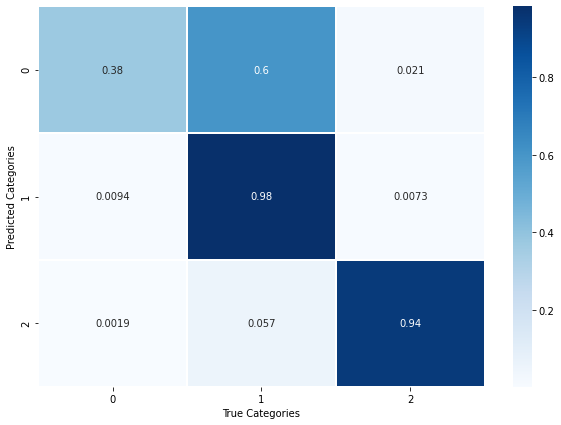

In [64]:
# Plot matrix as in paper
# Calculate what was mislabeled
df_pred_raw = pd.DataFrame(predictions)
target = df["class"].astype('category')
CM = confusion_matrix(target, df_pred_raw[0], labels=target.cat.categories, normalize="true")

df_matrix = pd.DataFrame(CM)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_matrix, annot=True, linewidths=.5, cmap="Blues")
ax.set_xlabel("True Categories")
ax.set_ylabel("Predicted Categories")

# Predict  
Just for fun, run model through Trump and Obama tweets

In [71]:
# Upload kaggle key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaiwang","key":"1871196faeeb11b3d8971cb002687266"}'}

In [75]:
# Move key to right place
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [74]:
# Download datasets from kaggle (Trump and Obama tweets dataset)
!kaggle datasets download -d datacrux/barack-obama-twitterdata-from-20122019
!kaggle datasets download -d austinreese/trump-tweets
!unzip barack-obama-twitterdata-from-20122019.zip
!unzip trump-tweets.zip

  0% 0.00/452k [00:00<?, ?B/s]
100% 452k/452k [00:00<00:00, 31.4MB/s]
 73% 5.00M/6.88M [00:00<00:00, 44.5MB/s]
100% 6.88M/6.88M [00:00<00:00, 44.2MB/s]
Archive:  barack-obama-twitterdata-from-20122019.zip
  inflating: Tweets-BarackObama.csv  
Archive:  trump-tweets.zip
  inflating: realdonaldtrump.csv     
  inflating: trumptweets.csv         


# Inference
Read in data and randomly pick n tweets
Run inference
Obtain ratios and pick 3 random tweets from each to show


In [81]:
# Read in data
df_trump = pd.read_csv("realdonaldtrump.csv")
df_obama = pd.read_csv("Tweets-BarackObama.csv")
# Discard everything except text
df_trump = df_trump["content"]
df_obama = df_obama["Tweet-text"]

In [87]:
# You can play with the size of sample or obtain a different random sample if you want
n = 1000
df_trump_sample = df_trump.sample(n).to_numpy() 
df_obama_sample = df_obama.sample(n).to_numpy()

In [120]:
# Run inference
tpred, _= model.predict(df_trump_sample)
opred, _= model.predict(df_obama_sample)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [89]:
# Read in
trump_stats = pd.DataFrame(tpred)
obama_stats = pd.DataFrame(opred)

# These results are for entertainment purposes only!

In [130]:
key = {
    0 : "HATE",
    1 : "OFFENSIVE",
    2 : "NEITHER"
}

In [267]:
# Select random tweets to look at for fun
# Re-run with CTRL-ENTER for refresh
r1 = random.randint(0, n)
r2 = random.randint(0, n)
r3 = random.randint(0, n)

print("TRUMP")
print(key[trump_stats.iloc[r1][0]], df_trump_sample[r1])
print(key[trump_stats.iloc[r2][0]], df_trump_sample[r2])
print(key[trump_stats.iloc[r3][0]], df_trump_sample[r3])
print("-----------------------------------------------------")
print("OBAMA")
print(key[obama_stats.iloc[r1][0]], df_obama_sample[r1])
print(key[obama_stats.iloc[r2][0]], df_obama_sample[r2])
print(key[obama_stats.iloc[r3][0]], df_obama_sample[r3])

TRUMP
NEITHER DEFEAT TERRORISM!https://twitter.com/RTErdogan/status/1184924506747482112 …
NEITHER It was my great honor to deliver the keynote address at the 2019 Second Step Presidential Justice Forum hosted by the 20/20 Bipartisan Justice Center in South Carolina, and my true honor to receive the Bipartisan Justice Award, thank you!https://www.pscp.tv/w/cINHzzFvTlFsTFJub1dwUXd8MU1ueG5FbmdhcW9KT99pFYaYe1C4ArvQ2DE-0gWmhGZ56k58_gydacO3TnKQ?t=1s …
NEITHER " @ WinPropP: @ UrplePingo My favorite person on twitter is @ realDonaldTrump" Thanks!
-----------------------------------------------------
OBAMA
NEITHER Second: Congress should restore a ban on military-style assault weapons and a 10-round limit for magazines.
NEITHER Carla's favorite part about the Affordable Care Act: Her daughter is covered. http://ofa.bo/iAZ  #ThisIsWhypic.twitter.com/GAxnTMXehd
NEITHER The Senate should not play political games with our Supreme Court.pic.twitter.com/RoNN4vaw0a


In [204]:
# Trump Totals
print("TRUMP")
print("Hate: {} Offensive: {} Neither: {}".format(trump_stats.value_counts()[0].iloc[0], trump_stats.value_counts()[1].iloc[0], trump_stats.value_counts()[2].iloc[0]))
print()
# Obama Totals
print("OBAMA")
print("Hate: {} Offensive: {} Neither: {}".format(obama_stats.value_counts()[0].iloc[0], obama_stats.value_counts()[1].iloc[0], obama_stats.value_counts()[2].iloc[0]))

TRUMP
Hate: 6 Offensive: 21 Neither: 973

OBAMA
Hate: 1 Offensive: 7 Neither: 992


# Custom Tweet Analysis
Pull from any twitter username and run inference!

In [279]:
# Please don't abuse my bearer_token, thank you
def get_tweets(username="lexfridman"):
    bearer_token = "AAAAAAAAAAAAAAAAAAAAAIF9KAEAAAAA6F6GFsIIxHE%2Fo%2BevV5M4ElB2HKw%3D1nLFrbDKX5pbUPc0CxAqcgn9YtMLqsffkI0uXGoVNYzH34yfI5"
    url = "https://api.twitter.com/2/tweets/search/recent?query=from:{}".format(username)
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    response = requests.request("GET", url, headers=headers)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return [i["text"] for i in response.json()["data"]]

In [280]:
# Enter custom username, I'm using @lexfridman as a placeholder
username = "lexfridman"
tweets = get_tweets(username)

200


In [282]:
# Run Inference
custom_preds, _ = model.predict(tweets)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [293]:
# Print results + tweet
for i in range(len(tweets)):
  print(key[custom_preds[i]], tweets[i])

NEITHER "Think lightly of yourself and deeply of the world." - Miyamoto Musashi
NEITHER AGI will need human supervision. https://t.co/wpFWuOG8Wl
NEITHER Diversity and inclusion of backgrounds, experiences, and ideas can only be built on a foundation of empathy and love not on a foundation of intolerance and dogmatic outrage.
NEITHER Why did Stalin only write in lowercase?

He was afraid of Capitalism.
NEITHER @ykilcher Lol. Your video is way better. I'm a big fan as you know. Keep creating and inspiring!
NEITHER RT @demishassabis: @lexfridman @DeepMind Thanks Lex, great video!
NEITHER I made a quick video on the basics of @DeepMind's AlphaFold 2, one of the biggest accomplishments in the history of AI and life sciences. Hope the video is useful. Congrats to @demishassabis, John Jumper, and team. https://t.co/oOTDXoBv3C https://t.co/Sy5EVyecft
NEITHER @elonmusk Both might as well be magic.
NEITHER Russian dolls are so full of themselves.
NEITHER DeepMind solving protein folding is an in